In [229]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [192]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math

In [5]:
!mkdir ../../yaml/march-13-2023
!mkdir ../../output/march-13-2023

In [21]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_lens = [300, 300]
cellular_transcript_copy_number = 50
transgene_transcript_copy_number = 25
ribosome_copy_number = 500
total_trna = 500
ribosome_binding_rates = [1000, 5000, 10000]
trna_charging_rate = 1000.0
transcript_names = ["cellularProtein", "GFP"]
trna_props = [(0.6, 0.4)]
#codon_comps_1 = (0.9, 0.1)
codon_comps_2 = [(0.6, 0.4), (0.1, 0.9)]

date = "march-13-2023"

Same setup at August 15, but increased the ribosome binding rate by an order of magnitude (hopefully to get the curves to flatten out a bit) and also added tRNA abundaces at 99:1 odds.

In [22]:
for trna_prop in trna_props:
    for comp in codon_comps_2:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[trna_prop, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../../yaml/{date}")

In [24]:
configs = os.listdir(f"../../yaml/{date}")
with open(f"../../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for ribosome_binding_rate in ribosome_binding_rates:
            for seed in range(1, 4):
                cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {transgene_transcript_copy_number} " + \
                  f"{ribosome_copy_number} {total_trna} {1000} {ribosome_binding_rate} {trna_charging_rate} {trna_charging_rate} ../output/{date}"
                stream.write(cmd)
                stream.write("\n")

In [ ]:
#parallel -j < cmd_files/march-13-2023.txt

In [4]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = pd.read_csv(f"{path}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    tmp["delta"] = tmp.groupby(["species"])["protein"].diff(periods=8)
    tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

In [34]:
df_master = None
for ribosome_binding_rate in ribosome_binding_rates:
    df_rib = None
    for codon_comp in codon_comps_2:
        path = f"../../output/{date}/two_codon_multi_transcript_0.6_0.4_{codon_comp[0]}_{codon_comp[1]}_0.6_0.4" + \
               f"_{cellular_transcript_copy_number}_{transgene_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
               f"_1000.0_{ribosome_binding_rate}.0_1000.0_1000.0"
        tmp = get_average_protein(path, 0.5, 500, 3)
        tmp["codon_comp"] = codon_comp[0]
        tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
        if df_rib is not None:
            df_rib = df_rib.append(tmp, ignore_index=True)
        else:
            df_rib = tmp
        df_rib["ribosome_binding"] = ribosome_binding_rate

    if df_master is not None:
        df_master = df_master.append(df_rib, ignore_index=True)
    else:
        df_master = df_rib

df_master = df_master[(df_master.time == 500.0)]
df_master = df_master[(df_master.ribosome_binding > 1000)]
df_master

,time,species,protein,delta,codon_comp,ribosome_binding
36,500.0,ATA_charged,198.000000,0.000000,0.6,5000
37,500.0,ATA_uncharged,2.000000,0.000000,0.6,5000
38,500.0,GFP,1564.666667,99.666667,0.6,5000
39,500.0,TTT_charged,299.333333,0.333333,0.6,5000
40,500.0,TTT_uncharged,0.666667,-0.333333,0.6,5000
41,500.0,__GFP_rbs,24.666667,-0.333333,0.6,5000
42,500.0,__cellularProtein_rbs,50.000000,0.000000,0.6,5000
43,500.0,free ribosome,492.333333,-0.333333,0.6,5000
44,500.0,cellularProtein,1275.333333,88.333333,0.6,5000
54,500.0,ATA_charged,199.000000,1.000000,0.1,5000


In [36]:
pivot = df_master.pivot(index = ["codon_comp", "ribosome_binding"], columns = "species", values = "protein").reset_index()
pivot["GFP"] = pivot["GFP"].fillna(0)

pivot["cellularProtein_transformed"] = pivot["cellularProtein"].groupby([pivot.codon_comp, pivot.ribosome_binding]).transform(lambda x: x/x.max())
pivot["GFP_transformed"] = pivot["GFP"] / (pivot["GFP"] + pivot["cellularProtein"])
pivot["Percent_opt"] = (pivot["codon_comp"] / 0.6 * 100).round().astype("int")
pivot["exp_cellularProtein"] = np.exp(pivot["cellularProtein_transformed"])


pivot

species,codon_comp,ribosome_binding,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,cellularProtein_transformed,GFP_transformed,Percent_opt,exp_cellularProtein
0,0.1,5000,199.000000,1.000000,1555.333333,298.000000,2.000000,25.000000,50.000000,1233.666667,491.333333,1.0,0.557667,17,2.718282
1,0.1,10000,196.666667,3.333333,3100.666667,299.333333,0.666667,25.000000,49.666667,1266.333333,484.000000,1.0,0.710022,17,2.718282
2,0.6,5000,198.000000,2.000000,1564.666667,299.333333,0.666667,24.666667,50.000000,1275.333333,492.333333,1.0,0.550939,100,2.718282
3,0.6,10000,199.000000,1.000000,3089.000000,297.666667,2.333333,25.000000,49.666667,1246.666667,487.333333,1.0,0.712463,100,2.718282


In [42]:
!mkdir ../../yaml/march-13-2023-2
!mkdir ../../output/march-13-2023-2

In [1]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_lens = [300, 300]
cellular_transcript_copy_number = 50
transgene_transcript_copy_number = 25
ribosome_copy_number = 250
total_trna = 500
ribosome_binding_rate = 10000.0
trna_charging_rates = [10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_props = [(0.6, 0.4)]
codon_comps_2 = [(0.6, 0.4)]

date = "march-13-2023-2"

In [53]:
for trna_prop in trna_props:
    for comp in codon_comps_2:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[trna_prop, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../../yaml/{date}")

In [54]:
configs = os.listdir(f"../../yaml/{date}")
with open(f"../../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for trna_chrg_rate in trna_charging_rates:
            for seed in range(1, 4):
                cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {transgene_transcript_copy_number} " + \
                  f"{ribosome_copy_number} {total_trna} {ribosome_binding_rate} {ribosome_binding_rate} {trna_chrg_rate} {trna_chrg_rate} ../output/{date}"
                stream.write(cmd)
                stream.write("\n")

In [8]:
df_master = None
for trna_chrg_rate in trna_charging_rates:
    path = f"../../output/{date}/two_codon_multi_transcript_0.6_0.4_0.6_0.4_0.6_0.4" + \
           f"_{cellular_transcript_copy_number}_{transgene_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
           f"_{ribosome_binding_rate}_{ribosome_binding_rate}_{trna_chrg_rate}_{trna_chrg_rate}"
    tmp = get_average_protein(path, 0.5, 500, 3)
    tmp["chrg_rate"] = trna_chrg_rate
    tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
    if df_master is not None:
        df_master = df_master.append(tmp, ignore_index=True)
    else:
        df_master = tmp

df_master = df_master[(df_master.time == 500.0)]
#df_master = df_master[(df_master.ribosome_binding > 1000)]
df_master

,time,species,protein,delta,chrg_rate
9,500.0,ATA_charged,56.666667,0.000000,10.0
10,500.0,ATA_uncharged,143.333333,0.000000,10.0
11,500.0,GFP,1235.666667,96.666667,10.0
12,500.0,TTT_charged,98.666667,23.000000,10.0
13,500.0,TTT_uncharged,201.333333,-23.000000,10.0
...,...,...,...,...,...
121,500.0,TTT_uncharged,1.000000,-1.333333,10000.0
122,500.0,__GFP_rbs,25.000000,0.333333,10000.0
123,500.0,__cellularProtein_rbs,49.666667,-0.333333,10000.0
124,500.0,free ribosome,230.666667,-2.333333,10000.0


In [11]:
pivot = df_master.pivot(index = ["chrg_rate"], columns = "species", values = "protein").reset_index()
pivot["GFP"] = pivot["GFP"].fillna(0)

pivot["cellularProtein_transformed"] = pivot["cellularProtein"].groupby([pivot.chrg_rate]).transform(lambda x: x/x.max())
pivot["GFP_transformed"] = pivot["GFP"] / (pivot["GFP"] + pivot["cellularProtein"])
pivot["exp_cellularProtein"] = np.exp(pivot["cellularProtein_transformed"])


pivot

species,chrg_rate,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,cellularProtein_transformed,GFP_transformed,exp_cellularProtein
0,10.0,56.666667,143.333333,1235.666667,98.666667,201.333333,24.666667,48.333333,4810.333333,202.000000,1.0,0.204378,2.718282
1,50.0,170.000000,30.000000,1494.333333,260.666667,39.333333,24.666667,49.666667,5745.666667,233.666667,1.0,0.206400,2.718282
2,100.0,178.666667,21.333333,1505.000000,268.000000,32.000000,25.000000,49.666667,5852.333333,226.666667,1.0,0.204558,2.718282
3,500.0,196.000000,4.000000,1518.666667,291.333333,8.666667,25.000000,49.666667,5860.333333,231.333333,1.0,0.205809,2.718282
4,1000.0,199.000000,1.000000,1498.333333,298.666667,1.333333,25.000000,49.000000,5904.000000,232.000000,1.0,0.202414,2.718282
5,5000.0,199.000000,1.000000,1507.333333,299.333333,0.666667,25.000000,49.666667,5904.333333,231.333333,1.0,0.203373,2.718282
6,10000.0,200.000000,0.000000,1507.000000,299.000000,1.000000,25.000000,49.666667,5962.333333,230.666667,1.0,0.201758,2.718282


In [12]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_lens = [300, 300]
cellular_transcript_copy_number = 50
transgene_transcript_copy_number = [5, 10, 20, 40, 80, 200]
ribosome_copy_number = 500
total_trna = 500
ribosome_binding_rate = 10000.0
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_props = [(0.6, 0.4)]
codon_comps_2 = [(0.6, 0.4), (0.4, 0.6), (0.1, 0.9)]

date = "march-16-2023-2"

In [13]:
!mkdir ../../yaml/march-16-2023
!mkdir ../../output/march-16-2023

In [14]:
for trna_prop in trna_props:
    for comp in codon_comps_2:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[trna_prop, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../../yaml/{date}")

In [15]:
configs = os.listdir(f"../../yaml/{date}")
with open(f"../../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in transgene_transcript_copy_number:
            for seed in range(1, 4):
                cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {copy_number} " + \
                  f"{ribosome_copy_number} {total_trna} {ribosome_binding_rate} {ribosome_binding_rate} {trna_charging_rate} {trna_charging_rate} ../output/{date}"
                stream.write(cmd)
                stream.write("\n")

In [19]:
df_master = None
transgene_transcript_copy_number = [5, 10, 20, 40, 80, 200]
for copy_number in transgene_transcript_copy_number:
    path = f"../../output/{date}/two_codon_multi_transcript_0.6_0.4_0.6_0.4_0.6_0.4" + \
           f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
           f"_{ribosome_binding_rate}_{ribosome_binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
    tmp = get_average_protein(path, 0.5, 500, 3)
    tmp["copy_number"] = copy_number
    tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
    if df_master is not None:
        df_master = df_master.append(tmp, ignore_index=True)
    else:
        df_master = tmp

df_master = df_master[(df_master.time == 500.0)]
#df_master = df_master[(df_master.ribosome_binding > 1000)]
df_master

,time,species,protein,delta,copy_number
9,500.0,ATA_charged,176.333333,5.000000,5
10,500.0,ATA_uncharged,23.666667,-5.000000,5
11,500.0,GFP,122.666667,12.333333,5
12,500.0,TTT_charged,261.333333,3.333333,5
13,500.0,TTT_uncharged,38.666667,-3.333333,5
14,500.0,__GFP_rbs,4.666667,-0.333333,5
15,500.0,__cellularProtein_rbs,49.333333,0.000000,5
16,500.0,free ribosome,472.333333,5.333333,5
17,500.0,cellularProtein,11834.666667,938.333333,5
27,500.0,ATA_charged,162.666667,-11.666667,10


In [20]:
pivot = df_master.pivot(index = ["copy_number"], columns = "species", values = "protein").reset_index()
pivot["GFP"] = pivot["GFP"].fillna(0)

pivot["cellularProtein_transformed"] = pivot["cellularProtein"].groupby([pivot.copy_number]).transform(lambda x: x/x.max())
pivot["GFP_transformed"] = pivot["GFP"] / (pivot["GFP"] + pivot["cellularProtein"])
pivot["exp_cellularProtein"] = np.exp(pivot["cellularProtein_transformed"])


pivot

species,copy_number,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,cellularProtein_transformed,GFP_transformed,exp_cellularProtein
0,5,176.333333,23.666667,122.666667,261.333333,38.666667,4.666667,49.333333,11834.666667,472.333333,1.0,0.010259,2.718282
1,10,162.666667,37.333333,488.000000,255.666667,44.333333,10.000000,49.000000,11669.666667,462.333333,1.0,0.040139,2.718282
2,20,170.666667,29.333333,1902.666667,261.333333,38.666667,19.666667,49.666667,11530.000000,466.000000,1.0,0.141645,2.718282
3,40,158.333333,41.666667,7171.333333,224.666667,75.333333,40.000000,49.333333,11207.000000,442.666667,1.0,0.390206,2.718282
4,80,116.000000,84.000000,23664.333333,176.666667,123.333333,79.666667,48.666667,9362.666667,357.666667,1.0,0.716515,2.718282
5,200,69.000000,131.000000,50576.000000,108.000000,192.000000,194.666667,49.333333,3291.000000,124.333333,1.0,0.938905,2.718282


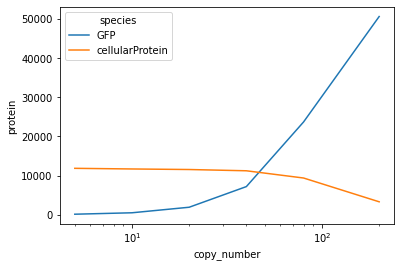

In [32]:
df_protein = df_master[(df_master.species == "GFP") | (df_master.species == "cellularProtein")]
sns.lineplot(data=df_protein, x = "copy_number", y = "protein", hue = "species")
plt.xscale("log")

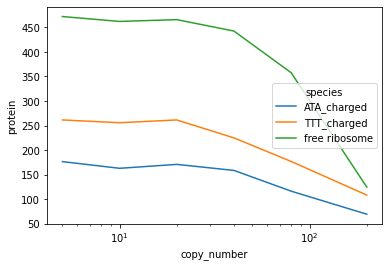

In [30]:
df_species = df_master[(df_master.species == "TTT_charged") | (df_master.species == "ATA_charged") | (df_master.species == "free ribosome")]
sns.lineplot(data=df_species, x = "copy_number", y = "protein", hue = "species")
plt.xscale("log")

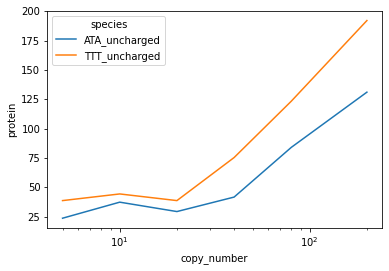

In [33]:
df_trna = df_master[(df_master.species == "TTT_uncharged") | (df_master.species == "ATA_uncharged")]
sns.lineplot(data=df_trna, x = "copy_number", y = "protein", hue = "species")
plt.xscale("log")

In [39]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_lens = [300, 300]
cellular_transcript_copy_number = 50
transgene_transcript_copy_number = [5, 10, 20, 40, 80, 200]
ribosome_copy_number = 500
total_trna = 500
ribosome_binding_rate = 10000.0
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_props = [(0.6, 0.4)]
codon_comps_2 = [(0.6, 0.4), (0.4, 0.6), (0.1, 0.9)]

date = "march-16-2023-2"

In [36]:
!mkdir ../../yaml/march-16-2023-2
!mkdir ../../output/march-16-2023-2

In [37]:
for trna_prop in trna_props:
    for comp in codon_comps_2:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[trna_prop, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../../yaml/{date}")

In [38]:
configs = os.listdir(f"../../yaml/{date}")
with open(f"../../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in transgene_transcript_copy_number:
            for seed in range(1, 4):
                cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {copy_number} " + \
                  f"{ribosome_copy_number} {total_trna} {ribosome_binding_rate} {ribosome_binding_rate} {trna_charging_rate} {trna_charging_rate} ../output/{date}"
                stream.write(cmd)
                stream.write("\n")

In [177]:
df_master = None

for copy_number in transgene_transcript_copy_number:
    df_copy = None
    for codons in codon_comps_2:
        path = f"../../output/{date}/two_codon_multi_transcript_0.6_0.4_{codons[0]}_{codons[1]}_0.6_0.4" + \
               f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
               f"_{ribosome_binding_rate}_{ribosome_binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
        tmp = get_average_protein(path, 0.5, 500, 3)
        tmp["codon"] = float(codons[0])
        tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
        if df_copy is not None:
            df_copy = df_copy.append(tmp, ignore_index=True)
        else:
            df_copy = tmp
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 500.0)]
df_master["codon"] = df_master["codon"].div(0.6).round(1)
#df_master = df_master[(df_master.ribosome_binding > 1000)]
df_master

,time,species,protein,delta,codon,copy_number
9,500.0,ATA_charged,176.333333,5.000000,1.0,5
10,500.0,ATA_uncharged,23.666667,-5.000000,1.0,5
11,500.0,GFP,122.666667,12.333333,1.0,5
12,500.0,TTT_charged,261.333333,3.333333,1.0,5
13,500.0,TTT_uncharged,38.666667,-3.333333,1.0,5
...,...,...,...,...,...,...
319,500.0,TTT_uncharged,25.333333,6.000000,0.2,200
320,500.0,__GFP_rbs,193.666667,2.666667,0.2,200
321,500.0,__cellularProtein_rbs,50.000000,0.000000,0.2,200
322,500.0,free ribosome,75.666667,-3.666667,0.2,200


In [178]:
pivot = df_master.pivot(index = ["copy_number", "codon"], columns = "species", values = "protein").reset_index()
pivot["GFP"] = pivot["GFP"].fillna(0)

pivot["cellularProtein_transformed"] = pivot["cellularProtein"].groupby([pivot.copy_number, pivot.codon]).transform(lambda x: x/x.max())
pivot["GFP_transformed"] = pivot["GFP"] / (pivot["GFP"] + pivot["cellularProtein"])
pivot["exp_cellularProtein"] = np.exp(pivot["cellularProtein_transformed"])


pivot

species,copy_number,codon,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,cellularProtein_transformed,GFP_transformed,exp_cellularProtein
0,5,0.2,173.000000,27.000000,121.000000,261.333333,38.666667,5.000000,49.000000,11750.000000,467.666667,1.0,0.010193,2.718282
1,5,0.7,166.666667,33.333333,119.666667,255.000000,45.000000,5.000000,49.666667,11735.666667,468.666667,1.0,0.010094,2.718282
2,5,1.0,176.333333,23.666667,122.666667,261.333333,38.666667,4.666667,49.333333,11834.666667,472.333333,1.0,0.010259,2.718282
3,10,0.2,168.000000,32.000000,462.333333,256.666667,43.333333,10.000000,49.666667,11774.666667,468.333333,1.0,0.037782,2.718282
4,10,0.7,168.666667,31.333333,480.666667,255.666667,44.333333,10.000000,48.666667,11825.333333,466.666667,1.0,0.039060,2.718282
5,10,1.0,162.666667,37.333333,488.000000,255.666667,44.333333,10.000000,49.000000,11669.666667,462.333333,1.0,0.040139,2.718282
6,20,0.2,162.333333,37.666667,1911.666667,258.666667,41.333333,20.000000,49.333333,11573.000000,462.333333,1.0,0.141766,2.718282
7,20,0.7,168.666667,31.333333,1923.000000,262.333333,37.666667,20.000000,49.666667,11621.666667,465.000000,1.0,0.141975,2.718282
8,20,1.0,170.666667,29.333333,1902.666667,261.333333,38.666667,19.666667,49.666667,11530.000000,466.000000,1.0,0.141645,2.718282
9,40,0.2,136.333333,63.666667,7073.666667,255.333333,44.666667,38.666667,49.333333,10998.000000,434.000000,1.0,0.391423,2.718282


In [158]:
sns.unset()

AttributeError: module 'seaborn' has no attribute 'unset'

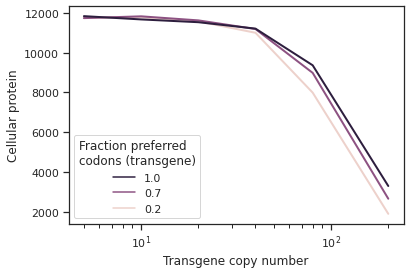

In [179]:
df_cellular = df_master[(df_master.species == "cellularProtein")]
sns.lineplot(data=df_cellular, x = "copy_number", y = "protein", hue = "codon", linewidth=2)
plt.xscale("log")
plt.xlabel("Transgene copy number")
plt.ylabel("Cellular protein")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred\ncodons (transgene)", loc="lower left")
plt.savefig(f"../../plots/rib-limiting/cellular_protein.png", bbox_inches="tight")

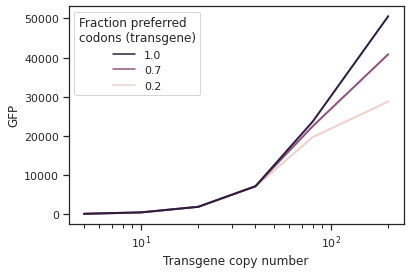

In [180]:
df_GFP = df_master[(df_master.species == "GFP")]
sns.lineplot(data=df_GFP, x = "copy_number", y = "protein", hue = "codon", linewidth=2)
plt.xscale("log")
plt.xlabel("Transgene copy number")
plt.ylabel("GFP")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred\ncodons (transgene)", loc="upper left")
plt.savefig(f"../../plots/rib-limiting/GFP.png", bbox_inches="tight")

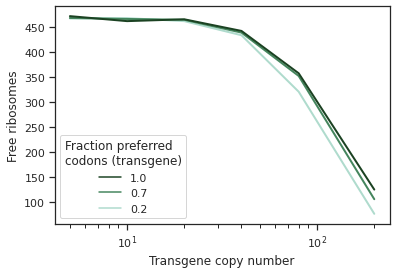

In [181]:
#palette = sns.light_palette("seagreen", as_cmap=True)
sns.set_theme(style="ticks", palette=None)
palette = sns.cubehelix_palette(start=1.9, rot=0.15, dark=0.2, light=.8, as_cmap=True)
df_rib = df_master[(df_master.species == "free ribosome")]
sns.lineplot(data=df_rib, x = "copy_number", y = "protein", hue = "codon", palette=palette, linewidth=2)
plt.xscale("log")
plt.xlabel("Transgene copy number")
plt.ylabel("Free ribosomes")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred\ncodons (transgene)", loc="lower left")
plt.savefig(f"../../plots/rib-limiting/ribosomes.png", bbox_inches="tight")

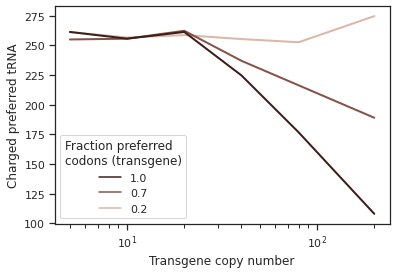

In [185]:
palette = sns.cubehelix_palette(start=0.95, rot=0.06, dark=0.15, light=.75, as_cmap=True)
df_TTT = df_master[(df_master.species == "TTT_charged")]
sns.lineplot(data=df_TTT, x = "copy_number", y = "protein", hue = "codon", palette=palette, linewidth=2)
plt.xscale("log")
plt.xlabel("Transgene copy number")
plt.ylabel("Charged preferred tRNA")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred\ncodons (transgene)", loc="lower left")
plt.savefig(f"../../plots/rib-limiting/preferred_tRNA.png", bbox_inches="tight")

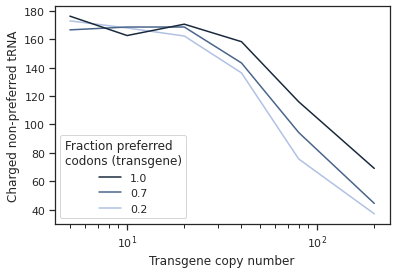

In [184]:
palette = sns.cubehelix_palette(start=2.7, rot=0.05, dark=0.15, light=.75, as_cmap=True)
df_ATA = df_master[(df_master.species == "ATA_charged")]
sns.lineplot(data=df_ATA, x = "copy_number", y = "protein", hue = "codon", palette=palette)
plt.xscale("log")
plt.xlabel("Transgene copy number")
plt.ylabel("Charged non-preferred tRNA")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred\ncodons (transgene)", loc="lower left")
plt.savefig(f"../../plots/rib-limiting/unpreferred_tRNA.png", bbox_inches="tight")

In [186]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_lens = [300, 300]
cellular_transcript_copy_number = 50
transgene_transcript_copy_number = [5, 10, 20, 40, 80, 200]
ribosome_copy_number = 500
total_trna = 500
ribosome_binding_rate = 10000.0
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_props = [(0.9, 0.1)]
codon_comps_2 = [(0.9, 0.1), (0.5, 0.5), (0.1, 0.9)]

date = "march-20-2023"

In [189]:
for trna_prop in trna_props:
    for comp in codon_comps_2:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[trna_prop, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../../yaml/{date}")

In [188]:
!mkdir ../../yaml/march-20-2023
!mkdir ../../output/march-20-2023

In [190]:
configs = os.listdir(f"../../yaml/{date}")
with open(f"../../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in transgene_transcript_copy_number:
            for seed in range(1, 4):
                cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {copy_number} " + \
                  f"{ribosome_copy_number} {total_trna} {ribosome_binding_rate} {ribosome_binding_rate} {trna_charging_rate} {trna_charging_rate} ../output/{date}"
                stream.write(cmd)
                stream.write("\n")

In [208]:
df_master = None

for copy_number in transgene_transcript_copy_number:
    df_copy = None
    for codons in codon_comps_2:
        path = f"../../output/{date}/two_codon_multi_transcript_0.9_0.1_{codons[0]}_{codons[1]}_0.9_0.1" + \
               f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
               f"_{ribosome_binding_rate}_{ribosome_binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
        tmp = get_average_protein(path, 0.5, 500, 3)
        tmp["codon"] = float(codons[0])
        tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
        if df_copy is not None:
            df_copy = df_copy.append(tmp, ignore_index=True)
        else:
            df_copy = tmp
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 500.0)]
df_master["codon"] = df_master["codon"].div(0.9).round(1)
#df_master = df_master[(df_master.ribosome_binding > 1000)]
df_master

,time,species,protein,delta,codon,copy_number
9,500.0,ATA_charged,43.666667,0.666667,1.0,5
10,500.0,ATA_uncharged,6.333333,-0.666667,1.0,5
11,500.0,GFP,124.000000,10.666667,1.0,5
12,500.0,TTT_charged,385.666667,-7.000000,1.0,5
13,500.0,TTT_uncharged,64.333333,7.000000,1.0,5
...,...,...,...,...,...,...
319,500.0,TTT_uncharged,4.333333,-1.666667,0.1,200
320,500.0,__GFP_rbs,185.000000,-5.666667,0.1,200
321,500.0,__cellularProtein_rbs,50.000000,0.333333,0.1,200
322,500.0,free ribosome,20.666667,-1.333333,0.1,200


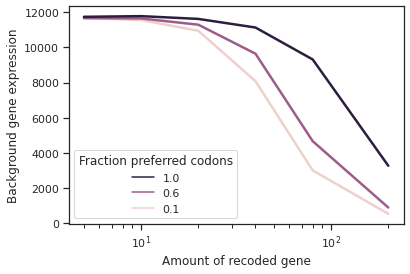

In [227]:
df_cellular = df_master[(df_master.species == "cellularProtein")]
sns.lineplot(data=df_cellular, x = "copy_number", y = "protein", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("Amount of recoded gene")
plt.ylabel("Background gene expression")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")
plt.savefig(f"../../plots/rib-limiting/cellular_protein.png", bbox_inches="tight")

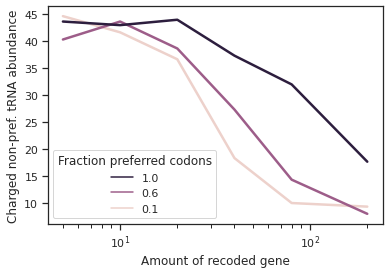

In [226]:
palette = sns.cubehelix_palette(start=2.7, rot=0.06, dark=0.15, light=.75, as_cmap=True)
df_ATA = df_master[(df_master.species == "ATA_charged")]
sns.lineplot(data=df_ATA, x = "copy_number", y = "protein", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("Amount of recoded gene")
plt.ylabel("Charged non-pref. tRNA abundance")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")
plt.savefig(f"../../plots/rib-limiting/unpreferred_tRNA.png", bbox_inches="tight")

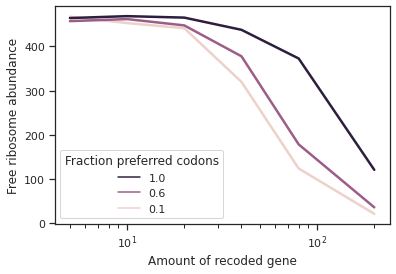

In [225]:
#palette = sns.light_palette("seagreen", as_cmap=True)
sns.set_theme(style="ticks", palette=None)
palette = sns.cubehelix_palette(start=1.9, rot=0.15, dark=0.2, light=.8, as_cmap=True)
df_rib = df_master[(df_master.species == "free ribosome")]
sns.lineplot(data=df_rib, x = "copy_number", y = "protein", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("Amount of recoded gene")
plt.ylabel("Free ribosome abundance")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")
plt.savefig(f"../../plots/rib-limiting/ribosomes.png", bbox_inches="tight")

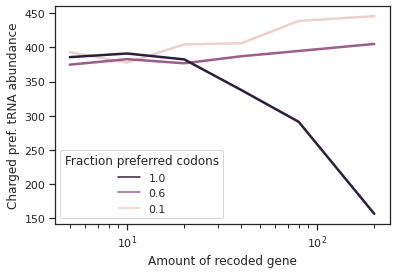

In [228]:
palette = sns.cubehelix_palette(start=0.95, rot=0.06, dark=0.15, light=.75, as_cmap=True)
df_TTT = df_master[(df_master.species == "TTT_charged")]
sns.lineplot(data=df_TTT, x = "copy_number", y = "protein", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("Amount of recoded gene")
plt.ylabel("Charged pref. tRNA abundance")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")
plt.savefig(f"../../plots/rib-limiting/preferred_tRNA.png", bbox_inches="tight")